# GCC-PHAT & SRP-PHAT

Given two signals $ x_{i}(n)$ and $ x_{j}(n)$ the GCC-PHAT is defined as:

$\displaystyle \hat{G}_{PHAT}(f) = \frac{X_{i}(f) [X_{j}(f)]^{*}}{\vert X_{i}(f) [X_{j}(f)]^{*}\vert}$, where $ X_{i}(f)$ and $ X_{j}(f)$ are the Fourier transforms of the two signals and $ [\ ]^{*}$ denotes the complex conjugate.

The TDOA for these two microphones is estimated as:

 $\displaystyle \hat{d}_{PHAT}(i,j) = {arg max \atop d} \big(\hat{R}_{PHAT}(d)\big)$, where $ \hat{R}_{PHAT}(d)$ is the inverse Fourier transform of the above function.

In [142]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.io import wavfile
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Create room setup

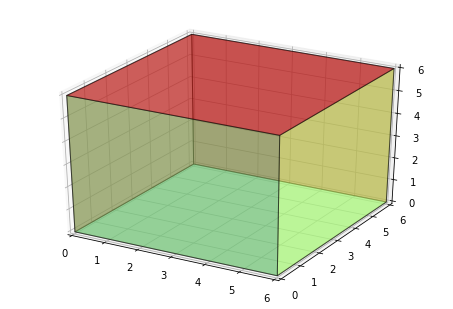

In [143]:
#Room dimensions
room_dimX, room_dimY, room_dimZ = 6, 6, 6
room_dim = np.array([room_dimX, room_dimY, room_dimZ])

#Sampling frequency
fs = 16000 # 16kHz

room = pra.ShoeBox(room_dim, fs=fs, max_order = 4, absorption=0.2)

# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_zlim([0, 6]);

Create microphone array

In [144]:
#Microphone position
R = np.c_[
    [3, 3.05, 3],  # mic 1
    [3, 2.95, 3],  # mic 2
    ]

distance = np.linalg.norm(R[:,0]-R[:,1])

# the fs of the microphones is the same as the room
mic_array = pra.MicrophoneArray(R, room.fs)

room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

In [145]:
def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan(y/x)
    
    return r, theta, phi

def spherical_to_cartesian(r, theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    return x, y, z

def changeOf_axes(posX, posY, posZ, room_dim):
    new_X = posX - room_dim[0]/2 
    new_Y = posY - room_dim[1]/2 
    new_Z = posZ - room_dim[2]/2 

    return new_X, new_Y, new_Z

Add source

In [146]:
fs, signal = wavfile.read("test1.wav")

posX, posY, posZ = 0.9, 3.5, 1.7


new_X, new_Y, new_Z = changeOf_axes(posX, posY, posZ, room_dim)
r_gt, theta_gt, phi_gt = cartesian_to_spherical(new_X, new_Y, new_Z)

#source_location = room_dim / 2 + np.array([new_X, new_Y, new_Z ])
source_location = np.array([posX, posY, posZ])

room.add_source(source_pos, signal=signal)

room.image_source_model(use_libroom=False)
room.compute_rir()

rir = room.rir

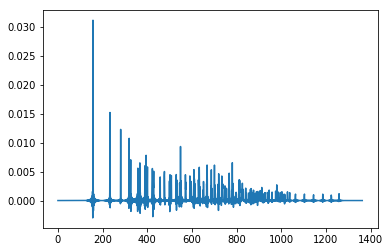

In [147]:
#plot the RIR between mic 0 and source
plt.plot(room.rir[0][0])
plt.show()

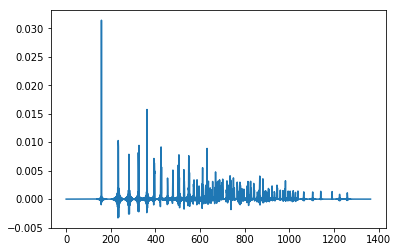

In [148]:
#plot the RIR between mic 1 and source
plt.plot(room.rir[1][0])
plt.show()

Simulate sound propagation

In [149]:
room.simulate()

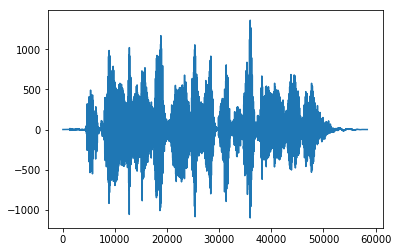

In [150]:
# plot signal at microphone 0
plt.plot(room.mic_array.signals[0,:])

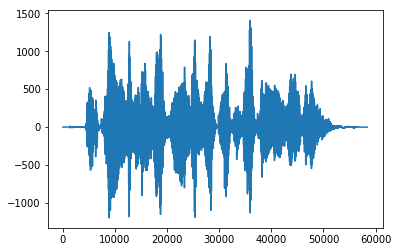

In [151]:
# plot signal at microphone 1
plt.plot(room.mic_array.signals[1,:])

In [152]:
def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    from : https://github.com/xiongyihui/tdoa/blob/master/gcc_phat.py
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [153]:
sound_speed = 343.2
max_tau = distance/sound_speed
tau, cc = gcc_phat(room.mic_array.signals[0,:], room.mic_array.signals[1,:], fs=fs, max_tau=max_tau)

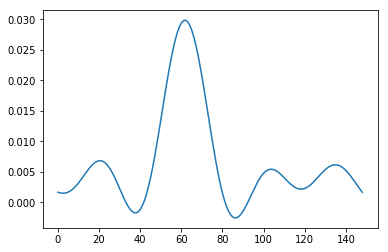

In [154]:
plt.plot(cc)

In [155]:
print("TDOA between the 2 microphone is: {tdoa}s".format(tdoa=abs(tau)))

TDOA between the 2 microphone is: 4.6875e-05s


### SRP PHAT

In [156]:
nfft = 256  # FFT size
freq_range = [300, 3500]
srp = pra.doa.srp.SRP(R, fs, nfft, r=1, dim=3, mode='near')

The DOA algorithms require an STFT input, which we will compute for overlapping frames for our 1 second duration signal.

In [157]:
X = np.array([pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T for signal in room.mic_array.signals])

In [158]:
srp.locate_sources(X,freq_range=freq_range, num_src=1)

In [159]:
phi_recon = srp.azimuth_recon[0]
theta_recon = srp.colatitude_recon[0]

In [160]:
phi_recon

3.053111246068301

In [161]:
phi_gt

-0.23374318086890142

In [162]:
theta_recon

2.1697340645179057

In [163]:
theta_gt

2.1128417166443336

In [114]:
r_ref, theta_ref, phi_ref = cartesian_to_spherical(posX, posY, posZ)


In [115]:
x_recon, y_recon, z_recon = spherical_to_cartesian(1, theta, phi)

In [116]:
phi

3.053111246068301

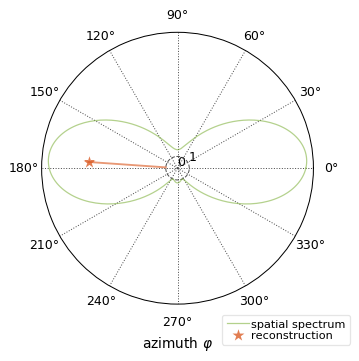

In [117]:
srp.polar_plt_dirac()

In [215]:
srp.colatitude_recon

array([0.43504316])